In [311]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import GridSearchCV
import pickle
import shap

In [312]:
# 讀取資料
df = pd.read_csv("./dataset/student_scores_clean.csv")


# df_male = df[df["gender"] == 1]
# print("Male students data shape:", df_male.shape)
# y = df_male
# sex = "male"

df_female = df[df["gender"] == 0]
print("Female students data shape:", df_female.shape)
y = df_female
sex = "female"

Female students data shape: (1002, 30)


In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   id                            2000 non-null   int64
 1   gender                        2000 non-null   int64
 2   part_time_job                 2000 non-null   int64
 3   absence_days                  2000 non-null   int64
 4   extracurricular_activities    2000 non-null   int64
 5   weekly_self_study_hours       2000 non-null   int64
 6   math_score                    2000 non-null   int64
 7   history_score                 2000 non-null   int64
 8   physics_score                 2000 non-null   int64
 9   chemistry_score               2000 non-null   int64
 10  biology_score                 2000 non-null   int64
 11  english_score                 2000 non-null   int64
 12  geography_score               2000 non-null   int64
 13  career_Accountant             200

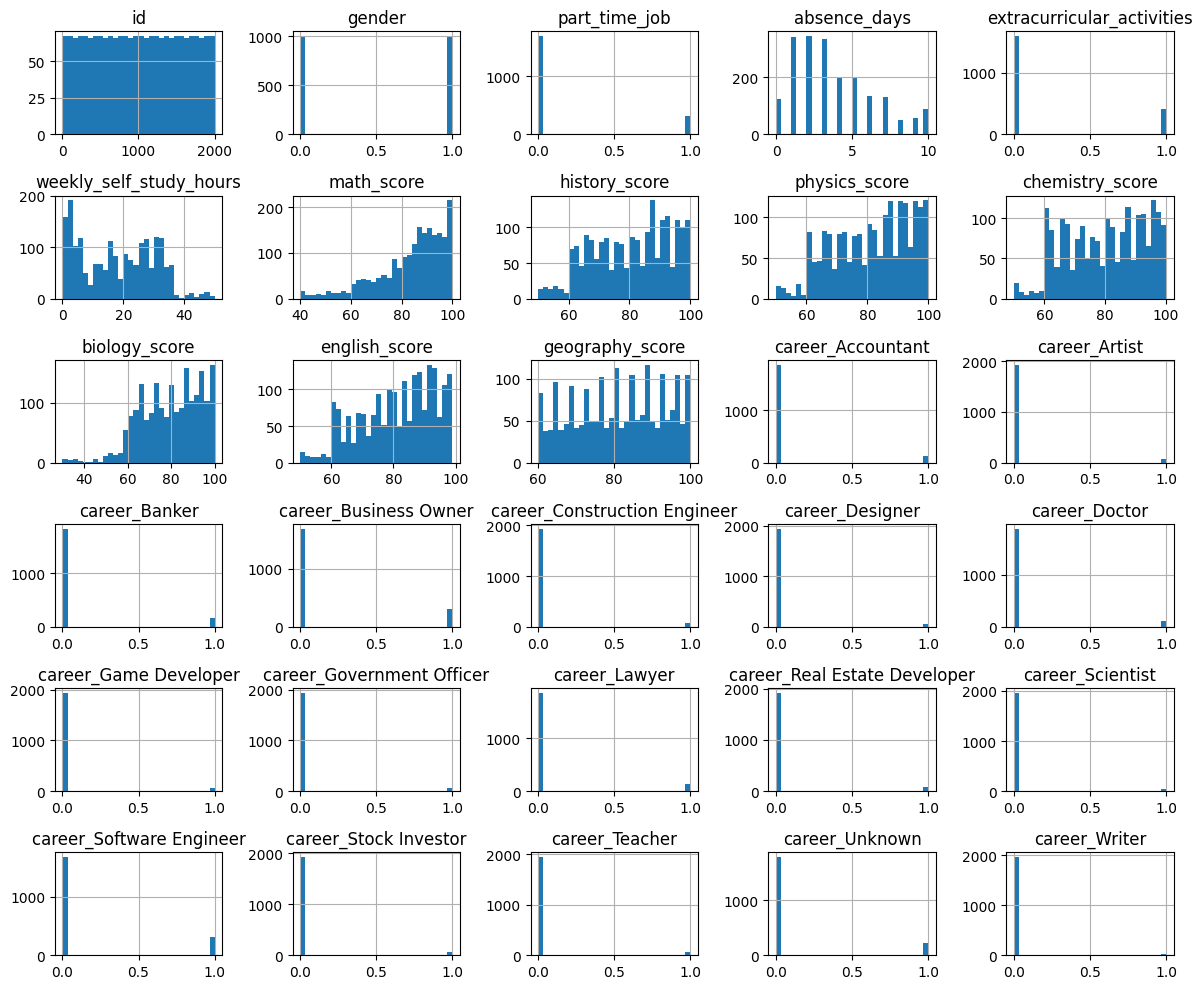

In [314]:
df.describe()
df.hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()


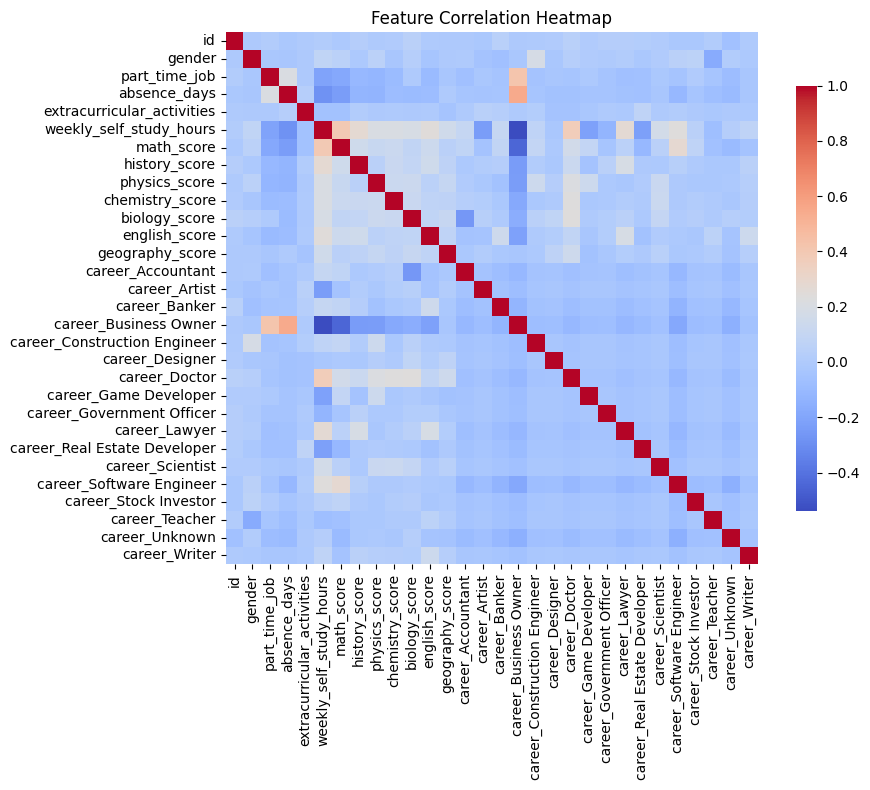

In [315]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 計算特徵間的皮爾森相關係數
corr = df.corr()

# 繪製熱圖
plt.figure(figsize=(10, 8))  # 調整圖大小
sns.heatmap(corr, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [316]:
career_columns = [col for col in df.columns if col.startswith("career_")]

features = [
    "part_time_job",
    "absence_days",
    "extracurricular_activities",
    "weekly_self_study_hours"
] + career_columns
# features.remove("career_Scientist")
# features.remove("career_Artist")
# features.remove("career_Teacher")
# features.remove("career_Accountant")

print("Features num:", len(features))

Features num: 21


In [317]:
X = df[features]

subject = "math"  # Change this to the subject you want to predict
# math
# history
# physics
# chemistry
# biology
# english
# geography
y = df[subject+ "_score"]
# y = (df["math_score"] + df["history_score"] + df["physics_score"] + 
#      df["chemistry_score"] + df["biology_score"] + df["english_score"] + 
#      df["geography_score"]) / 7


In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [319]:
# GridSearchCV 自動調整參數
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression

# 定義超參數範圍


param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.1, 1]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
# lr_model = LinearRegression()
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
# lr_model.fit(X_train, y_train)
# rf_model.fit(X_train, y_train)

# 輸出最佳參數與結果
print("最佳參數組合 (Best parameters):")
print(grid_search.best_params_)

print("最佳模型的負 RMSE (Best negative RMSE):")
print(grid_search.best_score_)

# 使用最佳模型預測測試集
best_model = grid_search.best_estimator_

with open(f'{sex}_result/model/xgb_{subject}_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
最佳參數組合 (Best parameters):
{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 1}
最佳模型的負 RMSE (Best negative RMSE):
-10.92978626296245


In [320]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.2f}") # 0~正無限大(越小越好)
print(f"MAE: {mae:.2f}") # 0~正無限大(越小越好)
print(f"R² 分數: {r2:.4f}") # 負無限大~1 (接近1越好)
print(f"RMSE: {rmse:.2f}") # 0~正無限大(越小越好)

MSE: 123.08
MAE: 8.89
R² 分數: 0.2583
RMSE: 11.09


                         Feature  Importance
7          career_Business Owner    0.493177
16      career_Software Engineer    0.127152
11         career_Game Developer    0.074388
19                career_Unknown    0.056340
3        weekly_self_study_hours    0.050838
2     extracurricular_activities    0.042468
10                 career_Doctor    0.040167
18                career_Teacher    0.022549
20                 career_Writer    0.020367
14  career_Real Estate Developer    0.018045
1                   absence_days    0.011198
8   career_Construction Engineer    0.009845
17         career_Stock Investor    0.009731
9                career_Designer    0.006178
0                  part_time_job    0.004865
6                  career_Banker    0.004560
12     career_Government Officer    0.004205
13                 career_Lawyer    0.003927
15              career_Scientist    0.000000
5                  career_Artist    0.000000
4              career_Accountant    0.000000


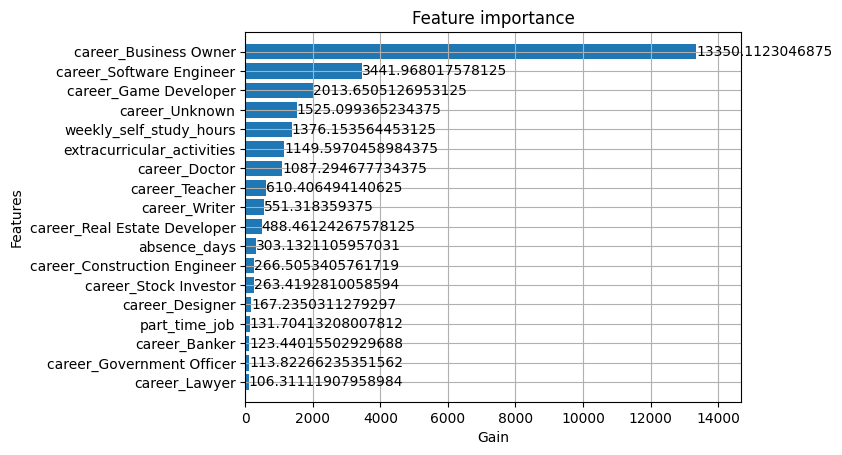

In [321]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(21))

plot_importance(best_model, importance_type='gain', 
                max_num_features=21, 
                xlabel='Gain',
                height=0.8)
plt.savefig(f"{sex}_result/feature_importance/xgb_{subject}.png", dpi=300, bbox_inches='tight')
plt.show()


In [322]:
mean_score = y_test.mean()
error_pct = rmse / mean_score * 100
print(f"相對誤差: {error_pct:.2f}%")

相對誤差: 13.24%


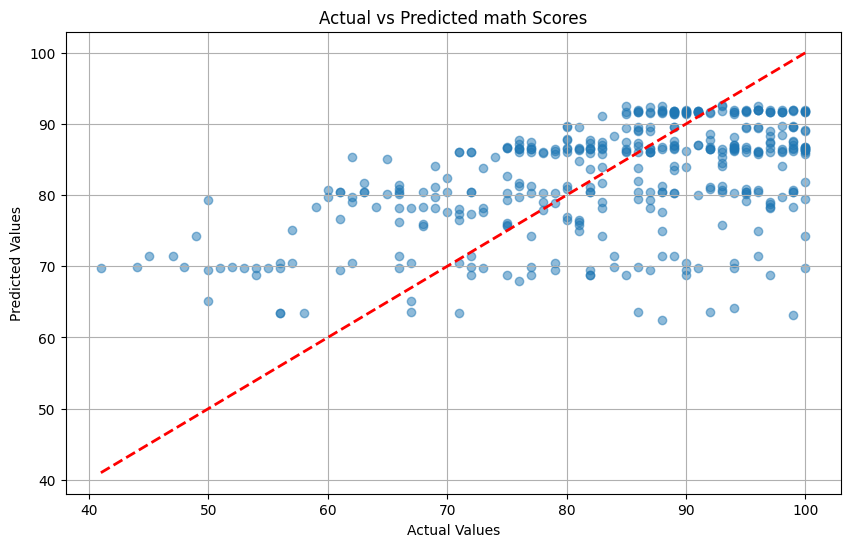

In [323]:
# 繪製實際值與預測值的散點圖
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Actual vs Predicted {subject} Scores')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.savefig(f"{sex}_result/actual_vs_predict/{subject}_scores.png", dpi=300, bbox_inches='tight')
plt.show()

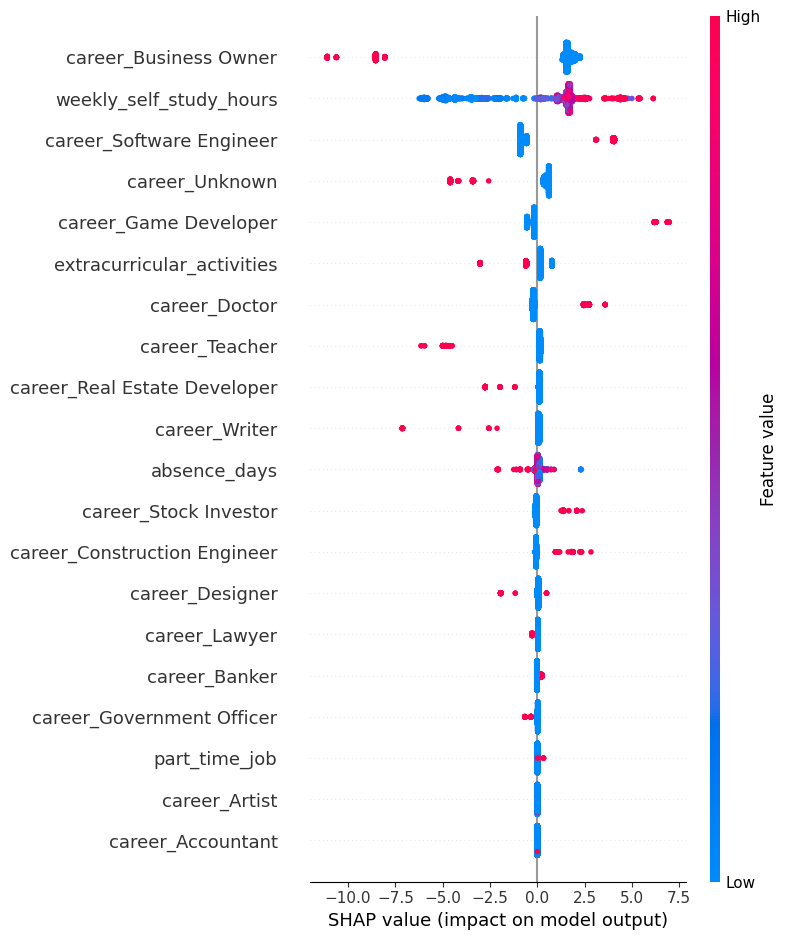

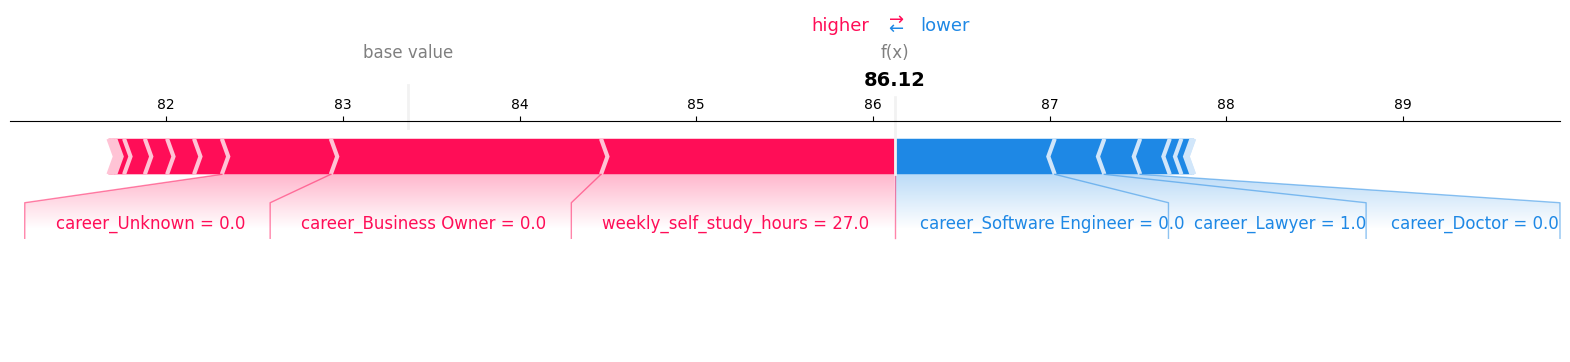

In [324]:
with open(f'{sex}_result/model/xgb_{subject}_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# 1. 建立 explainer
explainer = shap.Explainer(loaded_model)

# 2. 計算 SHAP 值
shap_values = explainer(X)

# 3. 畫 summary plot (全局特徵重要性及影響方向)
shap.summary_plot(shap_values, X)

# 4. 畫單筆解釋圖 (force plot)
# 假設要看第一筆資料的解釋
shap.force_plot(explainer.expected_value, shap_values[0].values, X.iloc[0], matplotlib=True)

plt.show()
